In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # To ignore SettingWithCopyWarning warning

# Import data

In [2]:
train = pd.read_csv("train.csv")
validation = pd.read_csv("validation.csv")

In [3]:
print(train.shape, validation.shape)

(2430981, 25) (303925, 25)


# Import Predictions

In [4]:
# lr_preds = pd.read_csv("Prediction_csv/lr_pCTR.csv", index_col  = "Unnamed: 0")
# rf_preds = pd.read_csv("Prediction_csv/rf_pCTR.csv", index_col  = "Unnamed: 0")
xgb_preds = pd.read_csv("Prediction_csv/xgb_pCTR.csv", index_col  = "Unnamed: 0")
# dwane_preds = pd.read_csv("Prediction_csv/click_predictions_narrow.csv")
lasso_preds = pd.read_csv("Prediction_csv/lasso_basebid.csv", index_col  = "Unnamed: 0")
# ridge_preds = pd.read_csv("Prediction_csv/ridge_basebid.csv", index_col  = "Unnamed: 0")
# elasticnet_preds = pd.read_csv("Prediction_csv/elasticnet_basebid.csv", index_col  = "Unnamed: 0")
# rfg_preds = pd.read_csv("Prediction_csv/rfg_basebid.csv", index_col  = "Unnamed: 0")
#xgbr_preds = pd.read_csv("Prediction_csv/xgb_basebid.csv", index_col  = "Unnamed: 0")

# Strategy

In [6]:
def Strategy3(sub_pCTR, sub_basebid, thresh):
    
    avgCTR = sub_pCTR["click_proba"].mean()
    sub_pCTR_ = sub_pCTR.copy()
    sub_pCTR_["click_proba"] = sub_pCTR_["click_proba"].map(lambda x: 0 if x < thresh else np.exp(x))
    bidprice = (sub_pCTR_["click_proba"] * sub_basebid["predicted_payprice"]) / avgCTR
    return bidprice

In [7]:
thresh_pCTR = np.linspace(0.05, 0.9, 70)
thresh_pCTR

array([0.05      , 0.06231884, 0.07463768, 0.08695652, 0.09927536,
       0.1115942 , 0.12391304, 0.13623188, 0.14855072, 0.16086957,
       0.17318841, 0.18550725, 0.19782609, 0.21014493, 0.22246377,
       0.23478261, 0.24710145, 0.25942029, 0.27173913, 0.28405797,
       0.29637681, 0.30869565, 0.32101449, 0.33333333, 0.34565217,
       0.35797101, 0.37028986, 0.3826087 , 0.39492754, 0.40724638,
       0.41956522, 0.43188406, 0.4442029 , 0.45652174, 0.46884058,
       0.48115942, 0.49347826, 0.5057971 , 0.51811594, 0.53043478,
       0.54275362, 0.55507246, 0.5673913 , 0.57971014, 0.59202899,
       0.60434783, 0.61666667, 0.62898551, 0.64130435, 0.65362319,
       0.66594203, 0.67826087, 0.69057971, 0.70289855, 0.71521739,
       0.72753623, 0.73985507, 0.75217391, 0.76449275, 0.77681159,
       0.78913043, 0.80144928, 0.81376812, 0.82608696, 0.8384058 ,
       0.85072464, 0.86304348, 0.87536232, 0.88768116, 0.9       ])

# Evaluate Results

In [8]:
budget = 6250*1000

def ValidationDataFrame(submission_pCTR, submission_basebid, thresh):
    
    validation_check = validation[["bidid", "click", "bidprice", "payprice"]]
    validation_check["click_proba"] = submission_pCTR["click_proba"]
    validation_check["basebid_predicted"] = submission_basebid["predicted_payprice"]
    validation_check["bidprice_predicted"] = Strategy3(submission_pCTR, submission_basebid, thresh)
    
    return validation_check

def ValidateStrategy(df):
    
    impressions = 0
    clicks = 0
    cost = 0
    auctions_participated = 0
    balance = budget
    
    for row in df.iterrows():
        
        if cost < budget:
            
            auctions_participated+=1
            
            if (row[1]["bidprice_predicted"] >= row[1]["payprice"]):
                
                
                impressions+=1
                clicks+=row[1]["click"]
                cost+=row[1]["payprice"]
                balance-=row[1]["payprice"]
                
#                 if (balance > row[1]["bidprice_predicted"]):
                    
#                     impressions+=1
#                     clicks+=row[1]["click"]
#                     cost+=row[1]["payprice"]
#                     balance-=row[1]["payprice"]
#                 else:
#                     pass
    
        else:
            break
    
    # Metrics
    ctr = clicks*100/impressions
    cpm = cost/impressions
    cpc = cost/clicks/1000
    
    print("Strategy statistics:")
    print("Auctions participated: {} | Impressions: {} | Clicks: {} | Cost: {} | CTR: {} | CPM: {} | CPC: {}".format(auctions_participated, \
                                                                                                                     impressions, clicks, \
                                                                                                                     cost,\
                                                                                                                     np.round(ctr,5), \
                                                                                                                np.round(cpm,5), \
                                                                                                                     np.round(cpc,2)))
    print("\n")
            
    return impressions, clicks, cost, auctions_participated, ctr, cpm, cpc

In [9]:
pCTR_model_name = "XGBoost"
results = pd.DataFrame(columns = ["pCTR thresh", "Impressions", "Clicks", "Cost", "CTR", "CPM", "CPC"])
i=0

start = time.time()

for thresh in thresh_pCTR:
    
    validation_check = ValidationDataFrame(xgb_preds, lasso_preds, thresh)
    print("\033[1m pCTR model: {} \033[0m, \033[1m Basebid model: {} \033[0m, \033[1m thresh: {} \033[0m".format("XGBoost", "Lasso", thresh))
    impressions, clicks, cost, auctions_participated, ctr, cpm, cpc = ValidateStrategy(validation_check)
    results.loc[i] = [thresh, impressions, clicks, cost, ctr, cpm, cpc]
    i+=1
    
end = time.time()
print("Total time: {} mins".format((end-start)/60))

 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.05 
Strategy statistics:
Auctions participated: 303925 | Impressions: 71137 | Clicks: 157 | Cost: 6240058 | CTR: 0.2207 | CPM: 87.71888 | CPC: 39.75


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.06231884057971015 
Strategy statistics:
Auctions participated: 303925 | Impressions: 56759 | Clicks: 153 | Cost: 5026994 | CTR: 0.26956 | CPM: 88.56735 | CPC: 32.86


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.0746376811594203 
Strategy statistics:
Auctions participated: 303925 | Impressions: 46718 | Clicks: 141 | Cost: 4159935 | CTR: 0.30181 | CPM: 89.04352 | CPC: 29.5


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.08695652173913043 
Strategy statistics:
Auctions participated: 303925 | Impressions: 39211 | Clicks: 138 | Cost: 3493104 | CTR: 0.35194 | CPM: 89.0848 | CPC: 25.31


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.09927536231884057 
Strategy statistics:
Auctions participated

Strategy statistics:
Auctions participated: 303925 | Impressions: 3307 | Clicks: 88 | Cost: 270796 | CTR: 2.66102 | CPM: 81.8857 | CPC: 3.08


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.46884057971014487 
Strategy statistics:
Auctions participated: 303925 | Impressions: 3132 | Clicks: 88 | Cost: 255804 | CTR: 2.80971 | CPM: 81.67433 | CPC: 2.91


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.48115942028985503 
Strategy statistics:
Auctions participated: 303925 | Impressions: 2983 | Clicks: 87 | Cost: 243539 | CTR: 2.91653 | CPM: 81.64231 | CPC: 2.8


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.49347826086956514 
Strategy statistics:
Auctions participated: 303925 | Impressions: 2845 | Clicks: 86 | Cost: 231943 | CTR: 3.02285 | CPM: 81.52654 | CPC: 2.7


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.5057971014492754 
Strategy statistics:
Auctions participated: 303925 | Impressions: 2702 | Clicks: 86 | Cost: 220333 | CTR: 3.18283 | CPM:

Strategy statistics:
Auctions participated: 303925 | Impressions: 498 | Clicks: 74 | Cost: 40463 | CTR: 14.85944 | CPM: 81.251 | CPC: 0.55


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.8876811594202898 
Strategy statistics:
Auctions participated: 303925 | Impressions: 460 | Clicks: 70 | Cost: 37079 | CTR: 15.21739 | CPM: 80.60652 | CPC: 0.53


 pCTR model: XGBoost ,  Basebid model: Lasso ,  thresh: 0.9 
Strategy statistics:
Auctions participated: 303925 | Impressions: 440 | Clicks: 69 | Cost: 34849 | CTR: 15.68182 | CPM: 79.20227 | CPC: 0.51


Total time: 26.509909546375276 mins


In [10]:
results.to_csv("ValidationSet_Evaluation_Results_Individual_xgb_lasso_pCTRthresh.csv")

In [14]:
results.sort_values(by = ["CTR"], ascending = False)

,pCTR thresh,Impressions,Clicks,Cost,CTR,CPM,CPC
69,0.900000,440.0,69.0,34849.0,15.681818,79.202273,0.505058
68,0.887681,460.0,70.0,37079.0,15.217391,80.606522,0.529700
67,0.875362,498.0,74.0,40463.0,14.859438,81.251004,0.546797
66,0.863043,529.0,74.0,42897.0,13.988658,81.090737,0.579689
65,0.850725,560.0,74.0,45694.0,13.214286,81.596429,0.617486
64,0.838406,589.0,75.0,48922.0,12.733447,83.059423,0.652293
63,0.826087,621.0,75.0,51834.0,12.077295,83.468599,0.691120
62,0.813768,659.0,75.0,54931.0,11.380880,83.355083,0.732413
61,0.801449,701.0,75.0,58564.0,10.699001,83.543509,0.780853
60,0.789130,744.0,76.0,63198.0,10.215054,84.943548,0.831553


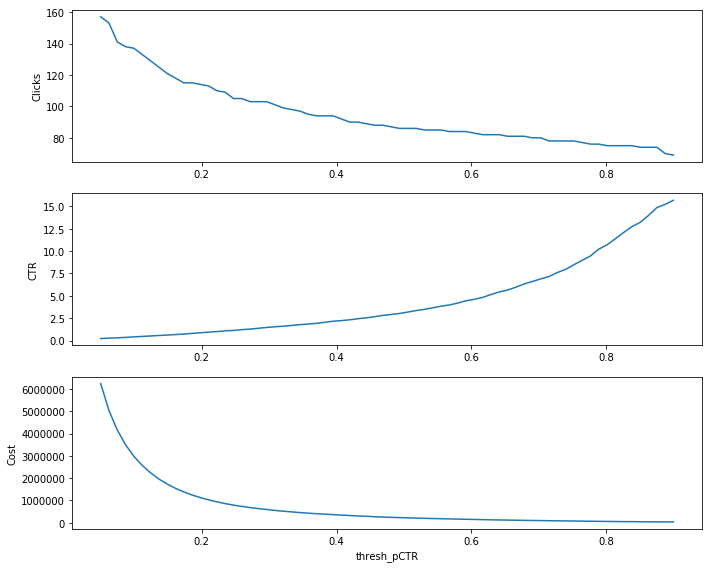

In [16]:
plt.figure(figsize = (10,8))

plt.subplot(3,1,1)
plt.plot(thresh_pCTR, results["Clicks"])
plt.ylabel("Clicks")

plt.subplot(3,1,2)
plt.plot(thresh_pCTR, results["CTR"])
plt.ylabel("CTR")

plt.subplot(3,1,3)
plt.plot(thresh_pCTR, results["Cost"])
plt.ylabel("Cost")
plt.xlabel("thresh_pCTR")

plt.tight_layout()